In [1]:
"""
ECGR 5105 - Intro to Machine Learning
Homework 4 - Part 2
Phillip Harmon
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
#Read in the CSV into a dataframe
csvData = pd.read_csv("./Housing.csv")

csvCols = len(csvData.columns)
csvRows = len(csvData)

dataLabels = ['price','area','bedrooms','bathrooms','stories','parking']
data = csvData[dataLabels]

boolLabels = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']
boolData = csvData[boolLabels]

def yn_bool_convert(val):
    return val.map({ "yes" : 1 , "no" : 0 })

boolData = boolData.apply(yn_bool_convert)

dataset = pd.concat([data,boolData],axis=1,join='outer')

dataset


price  area  bedrooms  bathrooms  stories  parking  mainroad  \
0    13300000  7420         4          2        3        2         1   
1    12250000  8960         4          4        4        3         1   
2    12250000  9960         3          2        2        2         1   
3    12215000  7500         4          2        2        3         1   
4    11410000  7420         4          1        2        2         1   
..        ...   ...       ...        ...      ...      ...       ...   
540   1820000  3000         2          1        1        2         1   
541   1767150  2400         3          1        1        0         0   
542   1750000  3620         2          1        1        0         1   
543   1750000  2910         3          1        1        0         0   
544   1750000  3850         3          1        2        0         1   

     guestroom  basement  hotwaterheating  airconditioning  prefarea  
0            0         0                0                1         1  
1            0         0                0                1         0  
2            0         1                0                0         1  
3            0         1                0                1         1  
4            1         1                0                1         0  
..         ...       ...              ...              ...       ...  
540          0         1                0                0         0  
541          0         0                0                0         0  
542          0         0                0                0         0  
543          0         0                0                0         0  
544          0         0                0                0         0  

[545 rows x 12 columns]

In [13]:
#Sort and clean the Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

x = dataset.iloc[:,1:-1].values
y = dataset.iloc[:,0].values

scaler = MinMaxScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y.reshape(len(y),1))


Mean Square Error for k=1 : 0.019142182400062203
Mean Square Error for k=2 : 0.012508623252327536
Mean Square Error for k=3 : 0.012057577267394445
Mean Square Error for k=4 : 0.012215030504956328
Mean Square Error for k=5 : 0.012336924027756229
Mean Square Error for k=6 : 0.010958769375877015
Mean Square Error for k=7 : 0.010254626182776064
Mean Square Error for k=8 : 0.009088906999969016
Mean Square Error for k=9 : 0.007941979300943007
Mean Square Error for k=10 : 0.008175404555258076


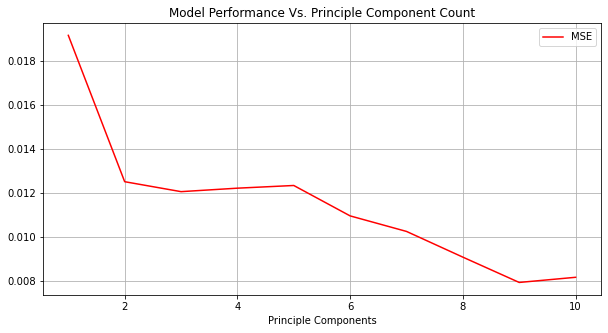

In [14]:
#Explore Default SVC with A range of PCA Component Counts
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

frameLog = []
modelLog = []
ypLog = []
cols = []
mseLog = []
maxPC = len(x[0])+1

for k in range(1,maxPC):
    
    pca = PCA(n_components = k)
    pcs = pca.fit_transform(x)
    cols.append('PC'+str(k))
    pcFrame = pd.DataFrame(data=pcs,columns=cols)
    frameLog.append(pcFrame)
    
    xt, xv, yt, yv = train_test_split(pcFrame, y,
                                      train_size = 0.8, test_size = 0.2,
                                      random_state=1337)
    
    model = SVR()
    model.fit(xt,yt.reshape(len(yt)));
    modelLog.append(model)
    
    yp = model.predict(xv)
    ypLog.append(yp)
    mse = mean_squared_error(yv,yp)
    mseLog.append(mse)
    print("Mean Square Error for k={} : {}".format(k,mse))

plt.rcParams["figure.figsize"] = (10,5)
plt.grid()
plt.xlabel('Principle Components')
plt.title('Model Performance Vs. Principle Component Count')
plt.plot(range(1,maxPC),mseLog,color='red',label='MSE')
plt.legend()
plt.show()


In [15]:
#Print Best Results
K = mseLog.index(min(mseLog))
print("According to the plot above,the lowest mean square error occurs at a lowest dimensionality of K={}"
      .format(K+1))
xt, xv, yt, yv = train_test_split(frameLog[K], y,train_size = 0.8, test_size = 0.2,random_state=1337)
yp = modelLog[K].predict(xv)
print("The Mean Square Error of this model is {}".format(mean_squared_error(yv,yp)))


According to the plot above,the lowest mean square error occurs at a lowest dimensionality of K=9
The Mean Square Error of this model is 0.007941979300943007


In [25]:
#Refresh the Dataset
x = dataset.iloc[:,1:-1].values
y = dataset.iloc[:,0].values

scaler = MinMaxScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y.reshape(len(y),1))

xt, xv, yt, yv = train_test_split(x, y,train_size = 0.8, test_size = 0.2,random_state=1337)


In [26]:
#Now to explore different Kernelizations and parameters
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import r2_score

kernels = ['rbf','linear','sigmoid','poly']

parameters = {
    'pca__n_components' : range(1,len(x[0])+1),
    'svr__C'          : [1,2,3,4,5,6,7,8,9,10],
    'svr__gamma'      : [0.000001,0.00001,0.0001,0.001,'auto','scale']
}

pca = PCA(random_state=1337)

modelLog = dict()
mseLog = dict()

for colonel in kernels:
    svr = SVR(kernel=colonel)
    pipeline = make_pipeline(pca,svr)

    grid = GridSearchCV(pipeline,parameters)

    print("\n===========================================================================================================")
    print("Searching a variety of Parameters to find the best model with {}-type kernelization...\n".format(colonel))
    %time grid.fit(xt,yt.reshape(len(yt)))
    print("\nBest model among all parameter options for {}-type kernelization:".format(colonel))
    print(grid.best_params_)
    
    yp = grid.predict(xv)
    mse = mean_squared_error(yv,yp)
    mseLog[colonel] = mse
    print("MSE Value for {}-type kernelization is {}".format(colonel,mse))
    
    modelLog[colonel] = grid



Searching a variety of Parameters to find the best model with rbf-type kernelization...

Wall time: 22.4 s

Best model among all parameter options for rbf-type kernelization:
{'pca__n_components': 10, 'svr__C': 1, 'svr__gamma': 'auto'}
MSE Value for rbf-type kernelization is 0.0071054664994934175

Searching a variety of Parameters to find the best model with linear-type kernelization...

Wall time: 31.7 s

Best model among all parameter options for linear-type kernelization:
{'pca__n_components': 10, 'svr__C': 1, 'svr__gamma': 1e-06}
MSE Value for linear-type kernelization is 0.007316419318936263

Searching a variety of Parameters to find the best model with sigmoid-type kernelization...

Wall time: 24.6 s

Best model among all parameter options for sigmoid-type kernelization:
{'pca__n_components': 10, 'svr__C': 3, 'svr__gamma': 'auto'}
MSE Value for sigmoid-type kernelization is 0.007431607456766796

Searching a variety of Parameters to find the best model with poly-type kernelizatio

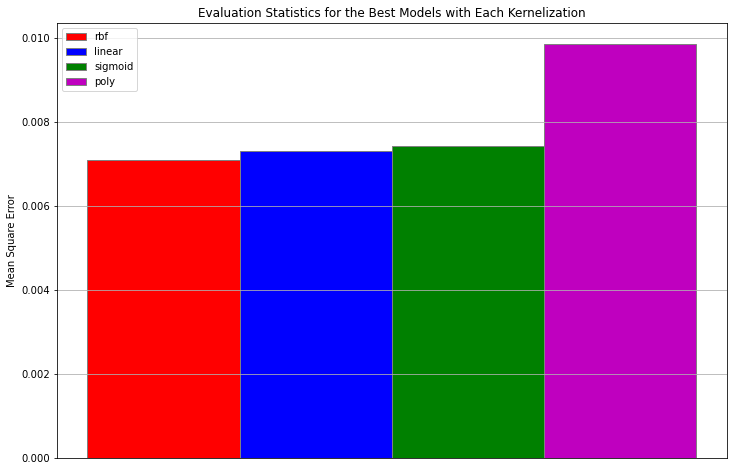

In [35]:
#Plot the results
w = 0.1
fig = plt.subplots(figsize = (12,8))

plt.bar(0, mseLog['rbf'], color='r', width=w, edgecolor='grey', label='rbf')
plt.bar(0.1, mseLog['linear'], color='b', width=w, edgecolor='grey', label='linear')
plt.bar(0.2, mseLog['sigmoid'], color='g', width=w, edgecolor='grey', label='sigmoid')
plt.bar(0.3, mseLog['poly'], color='m', width=w, edgecolor='grey', label='poly')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Mean Square Error")
plt.legend()
plt.title("Evaluation Statistics for the Best Models with Each Kernelization")
plt.grid(axis='y')
plt.show()